In [1]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Reading data from the csv file
#The csv file consists of TATA's OHLCV values of about 14 years
df = pd.read_csv(r"C:\Users\asugumar\Desktop\TATAMOTORS.NS.csv", parse_dates = ['Date'], index_col = 'Date')
df.sort_index(inplace = True)
df.tail(7)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-11,813.500000,817.500000,808.450012,815.650024,815.650024,11075167.0
2024-01-12,818.150024,818.549988,809.150024,816.450012,816.450012,7664094.0
2024-01-15,820.000000,820.400024,810.299988,812.450012,812.450012,4835856.0
2024-01-16,812.450012,827.000000,812.450012,818.849976,818.849976,10159066.0
2024-01-17,811.000000,813.700012,804.000000,805.549988,805.549988,7895439.0
2024-01-18,807.000000,822.950012,797.000000,819.049988,819.049988,11500495.0
2024-01-19,823.849976,826.000000,819.500000,823.549988,823.549988,5706888.0


In [3]:
df.isnull().sum()

Open         7
High         7
Low          7
Close        7
Adj Close    7
Volume       7
dtype: int64

In [4]:
#Data Cleaning and Pre-processing
#There are null values in each of the column. Let's fix the null values with it's local neighbourhood average.

def fillna_with_local_avg(series, window = 5):
    processed_series = series.copy()

    for i in range(window, len(series) - window):
        if pd.isnull(series[i]):
            window_values = list(series[i - window : i]) + list(series[i + 1 : i + window + 1])
            local_average = np.mean(window_values)
            processed_series[i] = local_average
    return processed_series

df['Open'] = fillna_with_local_avg(df['Open'], window = 5)
df['High'] = fillna_with_local_avg(df['High'], window = 5)
df['Low'] = fillna_with_local_avg(df['Low'], window = 5)
df['Close'] = fillna_with_local_avg(df['Close'], window = 5)
df['Adj Close'] = fillna_with_local_avg(df['Adj Close'], window = 5)
df['Volume'] = fillna_with_local_avg(df['Volume'], window = 5)

In [5]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

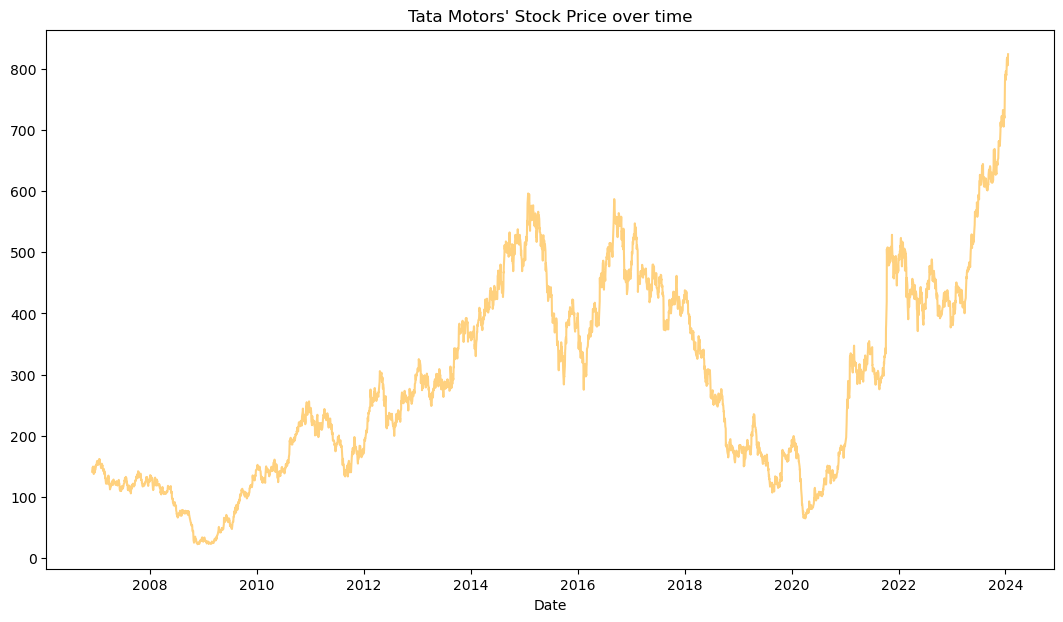

In [6]:
#Visualizing
plt.figure(figsize = (13,7))
plt.plot(df['Adj Close'], label = 'Original', alpha = 0.5, color = 'orange')
plt.title("Tata Motors' Stock Price over time")
plt.xlabel("Date")
plt.show()

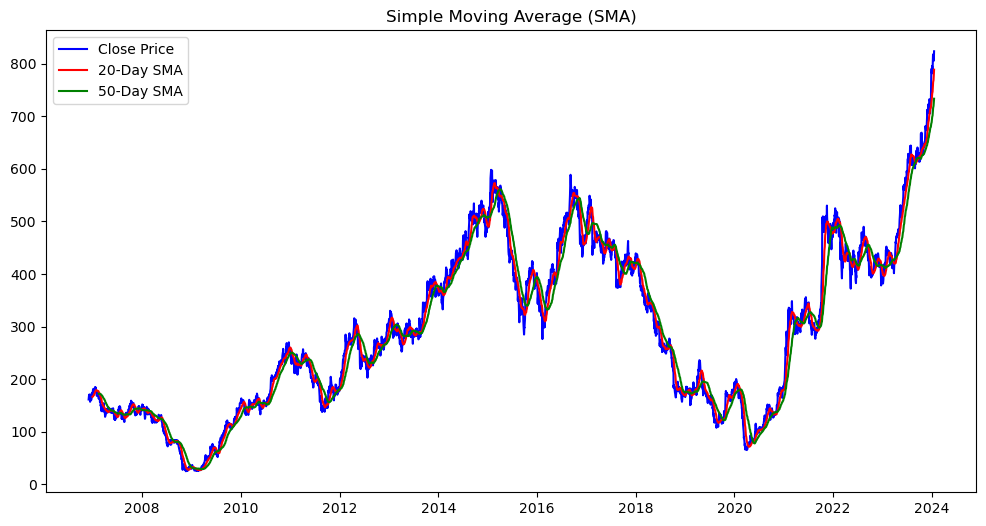

In [7]:
#Implementing Technical Analysis
# 1. Simple moving Average
# Calculate the 20-day and 50-day SMA
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Plot the closing price along with the SMA
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['SMA_20'], label='20-Day SMA', color='red')
plt.plot(df['SMA_50'], label='50-Day SMA', color='green')
plt.title('Simple Moving Average (SMA)')
plt.legend()
plt.show()

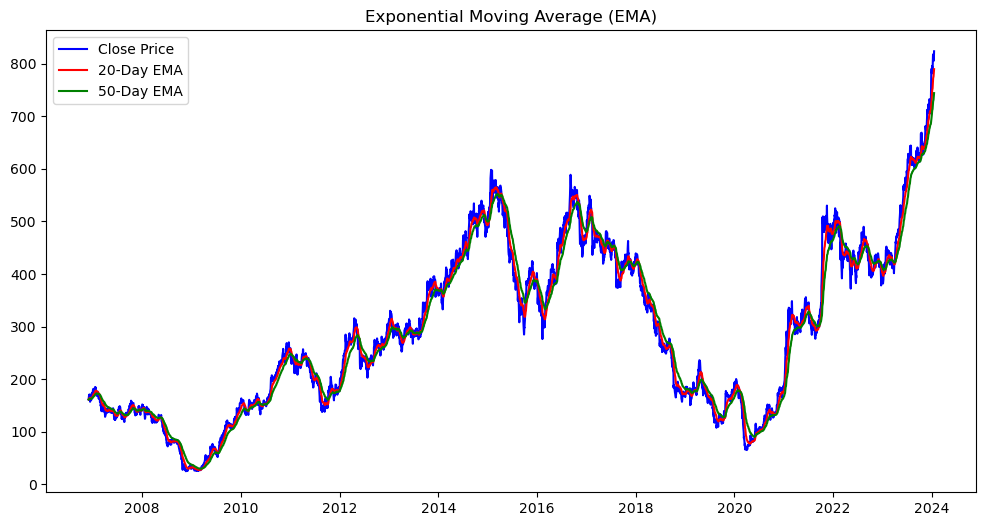

In [8]:
# 2. Exponential Moving Average
# Calculate the 20 day and 50 day EMA
df['EMA_20'] = df['Close'].ewm(span = 20, adjust = False).mean()
df['EMA_50'] = df['Close'].ewm(span = 50, adjust = False).mean()

# Plot the closing price along with the EMA
plt.figure(figsize = (12, 6))
plt.plot(df['Close'], label = 'Close Price', color ='blue')
plt.plot(df['EMA_20'], label ='20-Day EMA', color ='red')
plt.plot(df['EMA_50'], label ='50-Day EMA', color ='green')
plt.title('Exponential Moving Average (EMA)')
plt.legend()
plt.show()

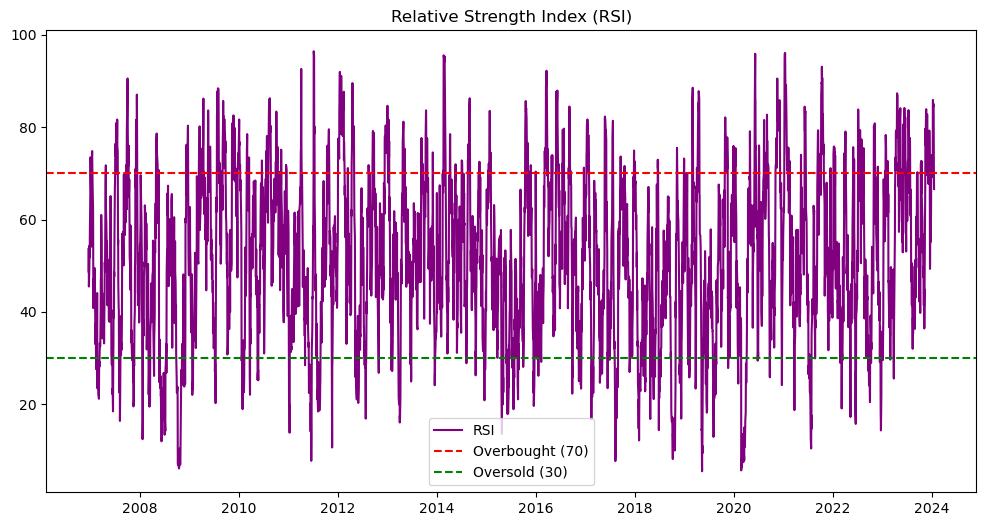

In [13]:
delta = df['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = - delta.where(delta < 0, 0)

average_gain = gain.rolling(14).mean()
average_loss = loss.rolling(14).mean()

rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))
df['RSI'] = rsi

# Plot the RSI
plt.figure(figsize=(12, 6))
plt.plot(df['RSI'], label='RSI', color='purple')
plt.title('Relative Strength Index (RSI)')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.legend()
plt.show()

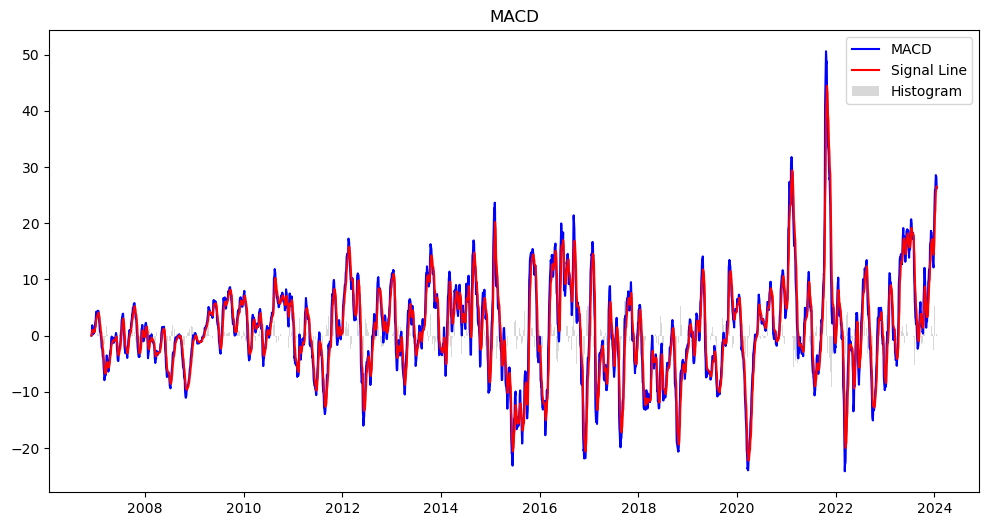

In [10]:
# Calculate the MACD and Signal Line
df['MACD'] = df['Close'].ewm(span = 12, adjust = False).mean() - df['Close'].ewm(span = 26, adjust = False).mean()
df['Signal Line'] = df['MACD'].ewm(span = 9, adjust = False).mean()

# Plot the MACD and Signal Line
plt.figure(figsize = (12, 6))
plt.plot(df['MACD'], label = 'MACD', color = 'blue')
plt.plot(df['Signal Line'], label = 'Signal Line', color = 'red')
plt.bar(df.index, df['MACD'] - df['Signal Line'], color = 'grey', alpha=0.3, label ='Histogram')
plt.title('MACD')
plt.legend()
plt.show()

In [13]:
# Compute daily return
df['Return'] = df['Close'].pct_change()

# Next day return
df['Next_Day_Return'] = df['Return'].shift(-1)

# Convert it into a binary signal
df['Signal'] = df['Next_Day_Return'].apply(lambda x: 1 if x > 0 else 0)  # 1 = Buy, 0 = Sell

In [15]:
#correlation analysis

df['Next_Day_Return'] = df['Close'].pct_change().shift(-1)

correlation = df[['MACD', 'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50']].corrwith(df['Next_Day_Return'])
print(correlation)

MACD      0.027537
SMA_20   -0.018976
EMA_20   -0.018754
SMA_50   -0.021807
EMA_50   -0.020974
dtype: float64


In [32]:
# We see that none of the features are correlated to Next_Day_Return
# Even if we force a model using these features, it is going to overfit. 
# Let's use Granger Causality Test to see if there's any correlation when lag is introduced.

In [18]:
#Lets perform granger test on RSI

from statsmodels.tsa.stattools import grangercausalitytests
df['Next_Day_Return'] = df['Close'].pct_change().shift(-1)
data_rsi = df[['Next_Day_Return', 'RSI']].dropna()

# Granger Causality Test on RSI
grangercausalitytests(data_rsi, maxlag=5, verbose=True)

# Granger Causality test on MACD
data_macd = df[['Next_Day_Return', 'MACD']].dropna()
grangercausalitytests(data_macd, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2574  , p=0.0124  , df_denom=4215, df_num=1
ssr based chi2 test:   chi2=6.2618  , p=0.0123  , df=1
likelihood ratio test: chi2=6.2572  , p=0.0124  , df=1
parameter F test:         F=6.2574  , p=0.0124  , df_denom=4215, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1314  , p=0.0438  , df_denom=4212, df_num=2
ssr based chi2 test:   chi2=6.2702  , p=0.0435  , df=2
likelihood ratio test: chi2=6.2655  , p=0.0436  , df=2
parameter F test:         F=3.1314  , p=0.0438  , df_denom=4212, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7639  , p=0.0026  , df_denom=4209, df_num=3
ssr based chi2 test:   chi2=14.3155 , p=0.0025  , df=3
likelihood ratio test: chi2=14.2912 , p=0.0025  , df=3
parameter F test:         F=4.7639  , p=0.0026  , df_denom=4209, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.9399  , p=0.

C:\ProgramData\miniconda3\envs\NeuralNetwork\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (2.732856193153306, 0.09837758102858796, 4228.0, 1),
   'ssr_chi2test': (2.7347953058731407, 0.09818408102399755, 1),
   'lrtest': (2.7339118404888723, 0.09823839541834538, 1),
   'params_ftest': (2.732856193153309, 0.09837758102858796, 4228.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.9488162667896345, 0.14257060738159322, 4225.0, 2),
   'ssr_chi2test': (3.9022451164592447, 0.1421144502654681, 2),
   'lrtest': (3.900446279778407, 0.1422423281076931, 2),
   'params_ftest': (1.9488162667897946, 0.14257060738151792, 4225.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.001144140217978, 0.11161613590592927, 4222.0, 3),
   'ssr_chi2test': (6.013386003539907, 0.11096078002377571, 3),
   'lrtest': (6.009114713786403, 0.11116761554754635, 3),
   'params_ftest': (2.001144140219386, 0.11161613590574715, 4222.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.,

In [33]:
# For RSI: lag3, lag4, lag5 are giving us very good p values (<0.01), these can be used for building more accurate model

In [19]:
# SMA_20
data_sma = df[['Next_Day_Return', 'SMA_20']].dropna()
grangercausalitytests(data_sma, maxlag=5)

# EMA_20
data_ema = df[['Next_Day_Return', 'EMA_20']].dropna()
grangercausalitytests(data_ema, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3561  , p=0.2443  , df_denom=4209, df_num=1
ssr based chi2 test:   chi2=1.3571  , p=0.2440  , df=1
likelihood ratio test: chi2=1.3569  , p=0.2441  , df=1
parameter F test:         F=1.3561  , p=0.2443  , df_denom=4209, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5177  , p=0.2193  , df_denom=4206, df_num=2
ssr based chi2 test:   chi2=3.0391  , p=0.2188  , df=2
likelihood ratio test: chi2=3.0380  , p=0.2189  , df=2
parameter F test:         F=1.5177  , p=0.2193  , df_denom=4206, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7743  , p=0.1498  , df_denom=4203, df_num=3
ssr based chi2 test:   chi2=5.3318  , p=0.1491  , df=3
likelihood ratio test: chi2=5.3284  , p=0.1493  , df=3
parameter F test:         F=1.7743  , p=0.1498  , df_denom=4203, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8454  , p=0.

{1: ({'ssr_ftest': (1.3035169806314455, 0.25363646113573063, 4228.0, 1),
   'ssr_chi2test': (1.3044418980727641, 0.25340345112305496, 1),
   'lrtest': (1.3042408558831085, 0.25344003312810603, 1),
   'params_ftest': (1.3035169806313323, 0.25363646113573063, 4228.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.069989028005439, 0.3431052104718866, 4225.0, 2),
   'ssr_chi2test': (2.1425105744203585, 0.34257821334791083, 2),
   'lrtest': (2.1419681628249236, 0.342671135145438, 2),
   'params_ftest': (1.0699890280046915, 0.34310521047191356, 4225.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.615390014058601, 0.04944085666473219, 4222.0, 3),
   'ssr_chi2test': (7.859178850867237, 0.04901349695557667, 3),
   'lrtest': (7.851885132040479, 0.04917405791744133, 3),
   'params_ftest': (2.6153900140925166, 0.04944085666247571, 4222.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

In [34]:
# For EMA_20: lag5 is giving us very good p value (<0.01), this can be used for building more accurate model

In [20]:
# SMA_50
data_sma = df[['Next_Day_Return', 'SMA_50']].dropna()
grangercausalitytests(data_sma, maxlag=5)

# EMA_50
data_ema = df[['Next_Day_Return', 'EMA_50']].dropna()
grangercausalitytests(data_ema, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7498  , p=0.1860  , df_denom=4179, df_num=1
ssr based chi2 test:   chi2=1.7510  , p=0.1857  , df=1
likelihood ratio test: chi2=1.7507  , p=0.1858  , df=1
parameter F test:         F=1.7498  , p=0.1860  , df_denom=4179, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3782  , p=0.2521  , df_denom=4176, df_num=2
ssr based chi2 test:   chi2=2.7598  , p=0.2516  , df=2
likelihood ratio test: chi2=2.7588  , p=0.2517  , df=2
parameter F test:         F=1.3782  , p=0.2521  , df_denom=4176, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1884  , p=0.3125  , df_denom=4173, df_num=3
ssr based chi2 test:   chi2=3.5713  , p=0.3116  , df=3
likelihood ratio test: chi2=3.5698  , p=0.3118  , df=3
parameter F test:         F=1.1884  , p=0.3125  , df_denom=4173, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2392  , p=0.

{1: ({'ssr_ftest': (1.6173263709164973, 0.20353493853057722, 4228.0, 1),
   'ssr_chi2test': (1.618473953488103, 0.20330470432482653, 1),
   'lrtest': (1.6181644769894774, 0.20334791510364605, 1),
   'params_ftest': (1.6173263709163561, 0.20353493853057722, 4228.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.5826055720410164, 0.2055608763455821, 4225.0, 2),
   'ssr_chi2test': (3.1689569560868636, 0.20505470576708193, 2),
   'lrtest': (3.1677705169095134, 0.2051763843227761, 2),
   'params_ftest': (1.582605572038858, 0.2055608763460159, 4225.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.538156376301451, 0.05483490564868169, 4222.0, 3),
   'ssr_chi2test': (7.62709378165242, 0.05438123954486213, 3),
   'lrtest': (7.620224224974663, 0.05454852729620209, 3),
   'params_ftest': (2.538156376816081, 0.054834905610917535, 4222.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.,

In [34]:
# For SMA_20, SMA_50: none of them is giving a good p value (<0.01), lets not use these

In [21]:
#Changing the feature variables based on Granger Causality Test
df['RSI_lag3'] = df['RSI'].shift(3)
df['RSI_lag4'] = df['RSI'].shift(4)
df['RSI_lag5'] = df['RSI'].shift(5)
df['MACD_lag5'] = df['MACD'].shift(5)
df['EMA20_lag5'] = df['EMA_20'].shift(5)
df['EMA50_lag5'] = df['EMA_50'].shift(5)

In [22]:
#Lets build a model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [36]:
# Let us first take a set of features and build a model using XGB Regressor

In [24]:
features = ['RSI_lag5', 'EMA20_lag5', 'MACD_lag5', 'EMA50_lag5', 'RSI_lag4'] 
X = df[features]
y = df['Close']  

In [35]:
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
r2_scores = []

for train_idx, test_idx in tscv.split(X):
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    print(f"RMSE: {rmse:.4f}  | R²: {r2:.4f}")

RMSE: 53.9307  | R²: -0.3162
RMSE: 143.9510  | R²: -1.0583
RMSE: 36.2080  | R²: 0.6748
RMSE: 19.9556  | R²: 0.9049
RMSE: 61.2268  | R²: 0.7418


In [37]:
# Fine tuning the feature sets in order to increase the R^2 value
features = ['RSI_lag5', 'EMA20_lag5', 'EMA50_lag5', 'RSI_lag4']
X = df[features]
y = df['Close'] 

In [27]:
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
r2_scores = []

for train_idx, test_idx in tscv.split(X):
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    print(f"RMSE: {rmse:.4f}  | R²: {r2:.4f}")

RMSE: 53.9528 | R²: -0.3173
RMSE: 144.3519 | R²: -1.0698
RMSE: 38.9329 | R²: 0.6240
RMSE: 21.1021 | R²: 0.8937
RMSE: 59.6971 | R²: 0.7546


In [28]:
# Fine tuning the feature sets in order to increase the R^2 value
features = ['RSI_lag5', 'EMA20_lag5', 'EMA50_lag5', 'RSI_lag4', 'RSI_lag3'] 
X = df[features]
y = df['Close'] 

In [29]:
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
r2_scores = []

for train_idx, test_idx in tscv.split(X):
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    print(f"RMSE: {rmse:.4f}  | R²: {r2:.4f}")

RMSE: 53.9307 | R²: -0.3162
RMSE: 143.9510 | R²: -1.0583
RMSE: 36.2080 | R²: 0.6748
RMSE: 19.9556 | R²: 0.9049
RMSE: 61.2268 | R²: 0.7418


In [ ]:
#Overall, the model exhibits strong predictive power in recent time windows, with an R² score as high as 0.90 and relatively low RMSE. 
#Earlier folds of the model showed weaker performance and it significantly improves in later periods. 
#The feature set derived using Granger causality and alternative data is more aligned with recent market behavior.
#This suggests a promising direction for forecasting Tata Motors stock returns using alternative indicators like MACD, EMA, and RSI.